# Book Recommendation

It is a Spark based project which recommends several books by calculating Pearson distances between the given book and the others. 

The dataset used in this projects was provided by the library of Istanbul Sehir University.

### HELLO WORLD

This part is to create Spark context and check if it works fine before moving on.

In [1]:
import findspark

findspark.init()

In [2]:
from pyspark import SparkConf
from pyspark.context import SparkContext

sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

test_rdd = sc.parallelize(["Hello", "World"])

test_rdd.take(1)

['Hello']

If what you see as output is ['Hello'] after running the cells above, you are ready to go!

### PROJECT

##### Data

The following cells are to read data from the csv files and merge them into a single dataframe by the column of book IDs.

In [3]:
from pyspark.sql import SQLContext

sql = SQLContext(sc)

df_books = sql.read.format("csv").load("data/data_books.csv", header="true", encoding="UTF-8", multiLine=True)
df_users = sql.read.format("csv").load("data/data_users.csv", header="true", encoding="UTF-8", multiLine=True)

In [4]:
df_books.printSchema()

root
 |-- ID: string (nullable = true)
 |-- CLASS: string (nullable = true)
 |-- TITLE: string (nullable = true)
 |-- SUBJECTS: string (nullable = true)



In [5]:
df_users.printSchema()

root
 |-- User_ID: string (nullable = true)
 |-- Books_ID: string (nullable = true)



In [6]:
df_merge = df_users.join(df_books, df_users.Books_ID == df_books.ID, "inner").selectExpr("User_ID", 
                                                                                         "Books_ID", 
                                                                                         "CLASS", 
                                                                                         "TITLE", 
                                                                                         "SUBJECTS")
df_merge.printSchema()

root
 |-- User_ID: string (nullable = true)
 |-- Books_ID: string (nullable = true)
 |-- CLASS: string (nullable = true)
 |-- TITLE: string (nullable = true)
 |-- SUBJECTS: string (nullable = true)



At this point, creation of the merged dataset has been successfully completed.

In [7]:
df_merge.show(10)

+---------+------------+-----------------+--------------------+--------------------+
|  User_ID|    Books_ID|            CLASS|               TITLE|            SUBJECTS|
+---------+------------+-----------------+--------------------+--------------------+
|pzkzczrly|000004169001|N 5300 .G6419/S26|Sanat?n öyküsü = ...|Art--History
Sana...|
|kzlcpzfll|000004169001|N 5300 .G6419/S26|Sanat?n öyküsü = ...|Art--History
Sana...|
|mzplkmfll|000004169001|N 5300 .G6419/S26|Sanat?n öyküsü = ...|Art--History
Sana...|
|mzlmacrzl|000004169001|N 5300 .G6419/S26|Sanat?n öyküsü = ...|Art--History
Sana...|
|mzlmacrzl|000004169001|N 5300 .G6419/S26|Sanat?n öyküsü = ...|Art--History
Sana...|
|      zzz|000007392001| PK 6418 .H35/M84|Mughal poetry : i...|Persian Poetry--M...|
|lzlkrmlyc|000007458001| PT 2653 .W42/K67|  Korku ruhu kemirir|German Literature...|
|kzfcpzzmk|000007458001| PT 2653 .W42/K67|  Korku ruhu kemirir|German Literature...|
|mzplkzzrk|000007458001| PT 2653 .W42/K67|  Korku ruhu kemirir|Ge

Each time a student either borrows a book or renews a loan, a new line was created for storing the transaction information as is seen in the table above. 

In [8]:
from pyspark.sql.functions import count

df_amount = df_merge.groupby("User_ID").agg(count("Books_ID").alias("Amount")).orderBy("Amount", ascending=False)

df_amount.show(10)

+---------+------+
|  User_ID|Amount|
+---------+------+
|       mf|   354|
|       zl|   242|
|      akz|   215|
|      zmz|   174|
|      fcm|    98|
|       my|    81|
|mzmyyzzay|    75|
|mzmyycmra|    69|
|mzkyzmmcp|    66|
|        z|    64|
+---------+------+
only showing top 10 rows



Text(0,0.5,'Transactions')

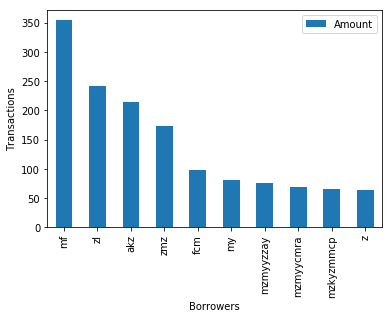

In [9]:
import matplotlib.pyplot as plt

%matplotlib inline

df_amount.toPandas().set_index("User_ID").iloc[:10].plot(kind="bar")
plt.xlabel("Borrowers")
plt.ylabel("Transactions")

Total number of transactions made by top-10 users is shown in the table as well as illustrated in the bar plot.

##### Recommendation

For building a simple recommendation system, the following type of data was needed:

In [ ]:
# sample = {book_id_1: {user_id_1: how many times user_id_1 borrowed book_id_1,
#                       user_id_2: how many times user_id_2 borrowed book_id_1},
#           book_id_2: {user_id_6: how many times user_id_6 borrowed book_id_2,
#                       user_id_8: how many times user_id_8 borrowed book_id_2,
#                       user_id_9: how many times user_id_9 borrowed book_id_2}}

Thereby, the data was grouped by book IDs and user IDs with the purpose of counting number of times that each book was borrowed by individual users.

In [11]:
df_period = df_merge.groupby("Books_ID", "User_ID").agg(count("User_ID").alias("Period"))

df_period.show(10)

+------------+---------+------+
|    Books_ID|  User_ID|Period|
+------------+---------+------+
|000079261001|kzaymcfll|     1|
|000079275001|mzkylcpac|     1|
|000101679001|      Ükp|     1|
|000101987001|mzlzrmpca|     1|
|000103434001|       Üm|     1|
|000104238001|       fz|     3|
|000104345001|mzkcfmmcl|     2|
|000104851001|mzazzzalf|     1|
|000108067001|      pcz|     1|
|000108808001|        z|     1|
+------------+---------+------+
only showing top 10 rows



The reason why number of borrowing periods was needed is to assume that lenght of having a book is directly proportionate to how much a user, who borrowed that book, has interest in content of the book.

In [16]:
df_json = df_period.toJSON()

In [13]:
import json

data = {}
for i in df_json.collect():
    entry = json.loads(i)
    if entry["Books_ID"] not in data.keys():
        data[entry["Books_ID"]] = {entry["User_ID"]: entry["Period"]}
    else:
        inner = data[entry["Books_ID"]]
        inner[entry["User_ID"]] = entry["Period"]
        data[entry["Books_ID"]] = inner

The data is finally prepared to use in the form stated at the beginning of this stage, which is called JSON format actually.

In [30]:
from typing import NoReturn
from lib.recommendations import top_matches

def get_recommendations(
    book_id: str, 
    n: int
) -> NoReturn:
    """
    This method finds the most similar books to the given one.
    :param book_id: ID of the book to find its similar.
    :param n: Number of similar books to find.
    :return:
    """
    
    matches = top_matches(prefs=data, person=book_id, n=n)
    for result in matches:
        print("Recommendation:\t{book_id},\tSimilarity:\t{score}".format(book_id=result[1], score=result[0]))

Lastly, top_matches method from recommendations module was used to find top 5 (or less) matches with a given book by calculating its Pearson distance to books in the data.

That is to say, users are now able to get recommendations according to books that they select.

##### Interface

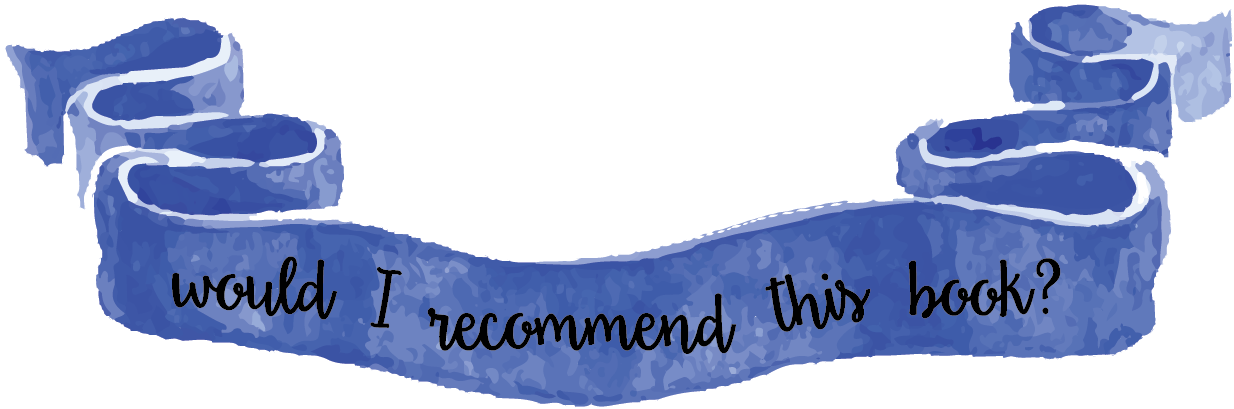

In [1]:
from IPython.display import Image

Image("img/header.png")

## Welcome!

#### Please follow the guide in order to get recommendations:

###### 1- Select how many recommendations that you want
###### 2- Enter your book's ID 
###### 3- Press Enter

#### That's it :)

## Have a great day!

In [2]:
from ipywidgets import widgets, interact
from IPython.display import display

n = 5

def f(x):
    global n
    
    n = x
    print("Number of recommendations (at most):\t", x)
    
interact(f, x=n)

interactive(children=(IntSlider(value=5, description='x', max=15, min=-5), Output()), _dom_classes=('widget-in…

<function __main__.f(x)>

In [48]:
text = widgets.Text()

display(text)

def handle_submit(sender):
    get_recommendations(text.value, abs(n))
    
text.on_submit(handle_submit)

A Jupyter Widget

Recommendation:	000111585001,	Similarity:	1.0
Recommendation:	000103668001,	Similarity:	1.0
Recommendation:	000103670001,	Similarity:	0.9
Recommendation:	000111716001,	Similarity:	0.69
Recommendation:	000132641001,	Similarity:	0.56
